In [ ]:
!pip install wget
import wget
wget.download("https://us13.mailchimp.com/mctx/clicks?url=https%3A%2F%2Fcs.stanford.edu%2Fgroup%2Fmlgroup%2FMURA-v1.1.zip&h=228d9b3e24f88cff940427d0ca11bbc0a3eadb6186fc9c39d05864f31fab3d4a&v=1&xid=ee08ea4f93&uid=55365305&pool=contact_facing&subject=MURA-v1.1%3A+Link+To+Dataset")
!unzip -q clicks
# !cp -r /content/MURA-v1.1/ /content/drive/'My Drive'/'Colab Notebooks'

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=0c8bb8359406a507e0660202e6511f6220731764e35d2dd6b4970bd9cf926069
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns 
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
import re
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score

from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten, MaxPool2D # Layers to be used for building our model
from tensorflow.keras.models import Model # The class used to create a model
from tensorflow.keras.optimizers import Adam
from tensorflow.random import set_seed
import tensorflow_addons as tfa
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
print("Tensorflow version " + tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Tensorflow version 2.2.0


In [ ]:
PATH="MURA-v1.1/"
train_x = pd.read_csv(PATH + 'train_image_paths.csv',header=None,names=['path'])
train_y = pd.read_csv(PATH + 'train_labeled_studies.csv',header=None,names=['path','label'])

In [ ]:
train_y['body part'] = train_y['path'].apply(lambda x: x.split('/')[2][3:])
train_y['study type'] = train_y['path'].apply(lambda x: x.split('/')[4][:6])

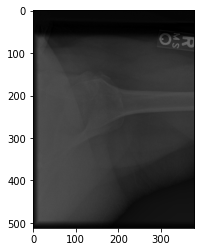

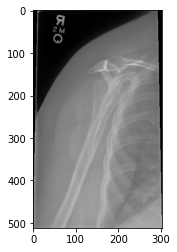

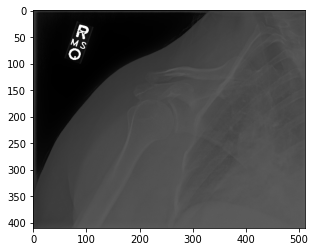

In [ ]:
for i in range(3):
  img = cv2.imread(f"/content/drive/My Drive/Colab Notebooks/{train_x.loc[i][0]}")
  plt.imshow(img)
  plt.show()


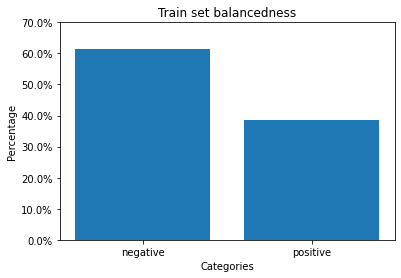

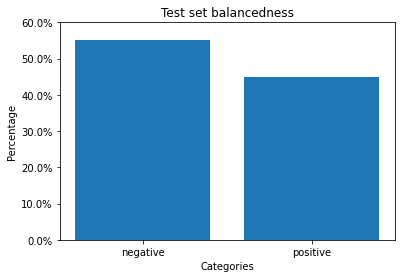

In [ ]:
plt.bar(train_y.groupby(['label']).count().index,train_y.groupby(['label']).count().path/len(train_y),
        tick_label=['negative','positive'])
plt.xlabel("Categories")
plt.ylabel("Percentage")
locs,labels = plt.yticks()
plt.yticks(locs,["{:.1%}".format(x) for x in locs])
plt.title("Train set balancedness")
plt.show()

plt.bar(test_y.groupby(['label']).count().index,test_y.groupby(['label']).count().path/len(test_y),
        tick_label=['negative','positive'])
plt.xlabel("Categories")
plt.ylabel("Percentage")
locs,labels = plt.yticks()
plt.yticks(locs,["{:.1%}".format(x) for x in locs])
plt.title("Test set balancedness")
plt.show()

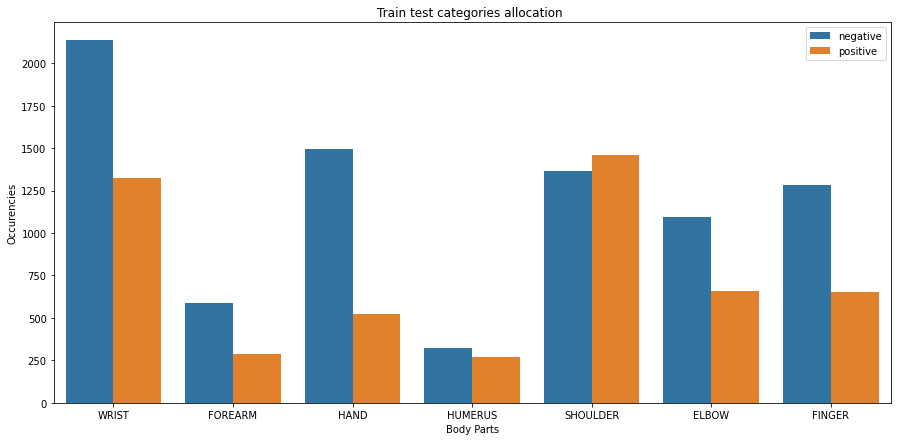

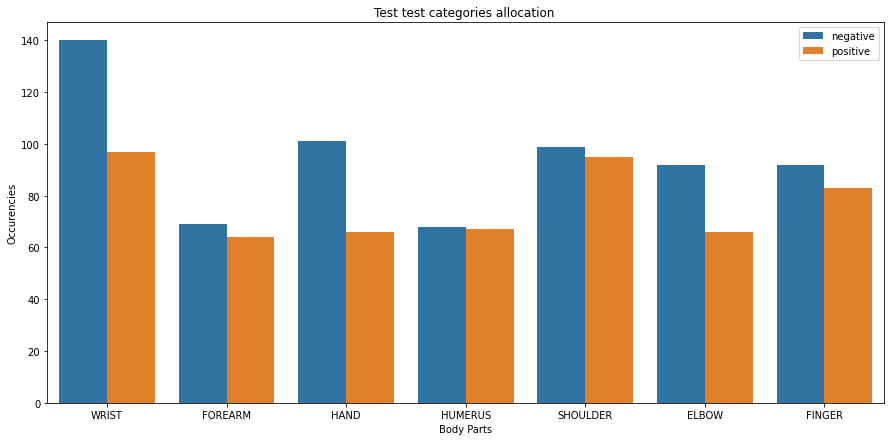

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(data=train_y,x='body part',order=['WRIST','FOREARM','HAND','HUMERUS','SHOULDER','ELBOW','FINGER'],hue='label')
plt.legend(["negative","positive"])
plt.xlabel("Body Parts")
plt.ylabel("Occurencies")
plt.title("Train test categories allocation ")
plt.show()
plt.figure(figsize=(15,7))
sns.countplot(data=test_y,x='body part',hue='label')
plt.xlabel("Body Parts")
plt.ylabel("Occurencies")
plt.legend(["negative","positive"])
plt.title("Test test categories allocation ")
plt.show()

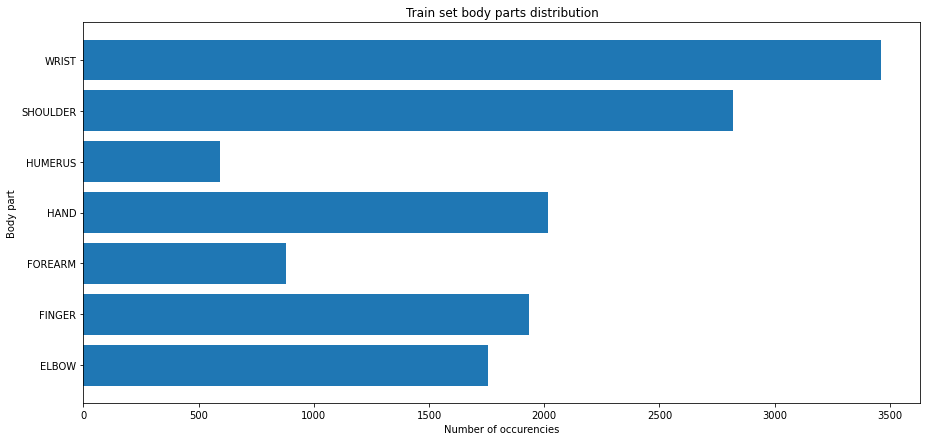

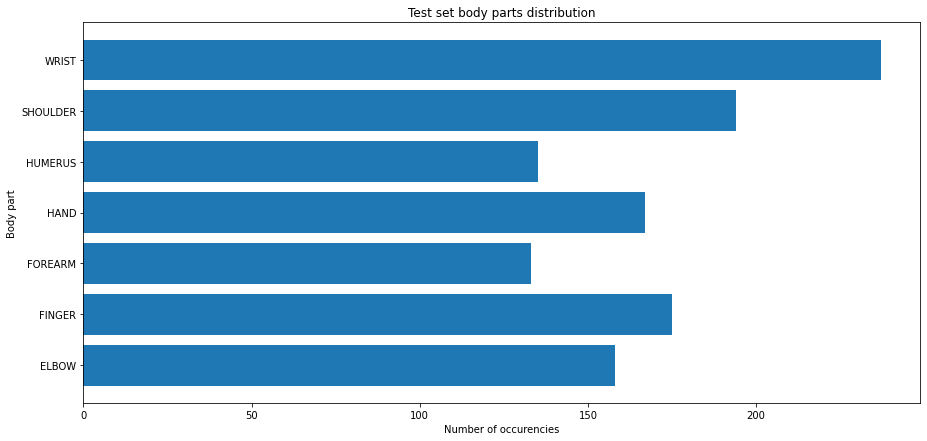

In [ ]:

plt.figure(figsize=(15,7))
plt.barh(train_y.groupby(['body part']).count().index,train_y.groupby(['body part']).count().path,)
plt.xlabel("Number of occurencies")
plt.ylabel("Body part")
plt.title("Train set body parts distribution")
plt.show()

plt.figure(figsize=(15,7))
plt.barh(test_y.groupby(['body part']).count().index,test_y.groupby(['body part']).count().path)
plt.xlabel("Number of occurencies")
plt.ylabel("Body part")
plt.title("Test set body parts distribution")
plt.show()

In [ ]:
def split_data(train_percentage):
  instances_nb = len(train_y)
  train_index = np.round(train_percentage * instances_nb).astype(int)
  validation = train_y.sample(frac=1,random_state = 4)[:train_index]
  train = train_y.sample(frac=1,random_state = 4)[train_index:]
  s = {"path" : []}
  for i in validation.path.values:
      s['path'].append(train_x[train_x.path.str.contains(i)].path)
  s['path'] = [item for sublist in s["path"] for item in sublist]

  val = pd.DataFrame(s)
  val.loc[val["path"].str.contains("positive"),"label"] = 1
  val.loc[val["path"].str.contains("negative"),"label"] = 0
  val.label = val.label.astype(int)
  val['body part'] = val['path'].apply(lambda x: x.split('/')[2][3:])

  t = {"path" : []}
  for i in train.path.values:
      t['path'].append(train_x[train_x.path.str.contains(i)].path)
  t['path'] = [item for sublist in t["path"] for item in sublist]

  train = pd.DataFrame(t)
  train.loc[train["path"].str.contains("positive"),"label"] = 1
  train.loc[train["path"].str.contains("negative"),"label"] = 0
  train.label = train.label.astype(int)
  train['body part'] = train['path'].apply(lambda x: x.split('/')[2][3:])


  print(f"Train data {len(train)} instances" )
  print('---')
  print(train.groupby(['body part','label']).count().path/len(train))

  print()
  print('====================')
  print()

  print(f"validation data {len(val)} instances")
  print('---')
  print(val.groupby(['body part','label']).count().path/len(val))

  print()
  print('====================')
  print()

  print(f"Test data {len(test_y)} instances")
  print('---')
  print(f"{test_y.groupby(['body part','label']).count().path/len(test_y)}")
  val.to_csv(path_or_buf="drive/My Drive/Colab Notebooks/data/validation.csv",index=False)
  train.to_csv(path_or_buf="drive/My Drive/Colab Notebooks/data/train.csv",index=False)
split_data(0.1)

Train data 33170 instances
---
body part  label
ELBOW      0        0.079409
           1        0.053964
FINGER     0        0.085197
           1        0.054567
FOREARM    0        0.031504
           1        0.017486
HAND       0        0.109828
           1        0.041363
HUMERUS    0        0.018300
           1        0.015556
SHOULDER   0        0.114561
           1        0.113084
WRIST      0        0.155924
           1        0.109255
Name: path, dtype: float64


validation data 3638 instances
---
body part  label
ELBOW      0        0.079989
           1        0.059373
FINGER     0        0.085761
           1        0.043430
FOREARM    0        0.032710
           1        0.022265
HAND       0        0.114349
           1        0.030786
HUMERUS    0        0.018142
           1        0.022815
SHOULDER   0        0.112974
           1        0.114623
WRIST      0        0.163002
           1        0.099780
Name: path, dtype: float64


Test data 1199 instances
---
b

In [ ]:
test= pd.read_csv('MURA-v1.1/valid_image_paths.csv',header=None,names=['path'])
test.loc[test["path"].str.contains("positive"),"label"] = 1
test.loc[test["path"].str.contains("negative"),"label"] = 0
test.label = test.label.astype(int)
test.to_csv(path_or_buf="drive/My Drive/Colab Notebooks/data/test.csv",index=False)

In [ ]:
train = pd.read_csv("drive/My Drive/Colab Notebooks/data/train.csv",dtype=str)
val = pd.read_csv("drive/My Drive/Colab Notebooks/data/validation.csv",dtype=str)
test = pd.read_csv("drive/My Drive/Colab Notebooks/data/test.csv",dtype=str)

image_generator = ImageDataGenerator(rescale=1./255)
train_generator = image_generator.flow_from_dataframe(train,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4)
val_generator = image_generator.flow_from_dataframe(val,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4)
test_generator = image_generator.flow_from_dataframe(test,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4)

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 33170 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3638 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3197 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    # x_ticks = np.arange(0, epochs + 1, epochs / 10)
    # x_ticks [0] += 1
    # plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


In [ ]:
class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)


In [ ]:
def predict(pred_train,pred_val,*pred_test):
    train['patient'] = train.path.apply(lambda x: re.sub("image[0-9].png","",x))
    val['patient'] = val.path.apply(lambda x: re.sub("image[0-9].png","",x))
    train_final = pd.concat([train,pd.DataFrame(pred_train,columns=['Probability'])],axis=1)
    val_final = pd.concat([val,pd.DataFrame(pred_val,columns=['Probability'])],axis=1)

    kappa = []
    range = np.linspace(0,1,20)
    for i in range:
      def assign(x):
        if x >= i:
          x = 1
        else:
          x = 0
        return x

      predictions_val = pd.concat([val_final.groupby(['patient'],as_index=False).mean(),pd.DataFrame(val_final.groupby(['patient'],as_index=False).mean().Probability.apply( assign).rename("label"))],axis=1)

      predictions_val.loc[predictions_val["patient"].str.contains("positive"),"true_label"] = 1
      predictions_val.loc[predictions_val["patient"].str.contains("negative"),"true_label"] = 0

      predictions_val.true_label = predictions_val.true_label.astype(int)
      kappa.append(cohen_kappa_score(predictions_val.true_label.values,predictions_val.label.values))
    
    t = np.argmax(kappa)
    t = range[t]
    def assign(x):
        if x >= t:
          x = 1
        else:
          x = 0
        return x
 
    predictions_train = pd.concat([train_final.groupby(['patient'],as_index=False).mean(),pd.DataFrame(train_final.groupby(['patient'],as_index=False).mean().Probability.apply( assign).rename("label"))],axis=1)
    predictions_val = pd.concat([val_final.groupby(['patient'],as_index=False).mean(),pd.DataFrame(val_final.groupby(['patient'],as_index=False).mean().Probability.apply( assign).rename("label"))],axis=1)

    predictions_train.loc[predictions_train["patient"].str.contains("positive"),"true_label"] = 1
    predictions_train.loc[predictions_train["patient"].str.contains("negative"),"true_label"] = 0

    predictions_val.loc[predictions_val["patient"].str.contains("positive"),"true_label"] = 1
    predictions_val.loc[predictions_val["patient"].str.contains("negative"),"true_label"] = 0

    predictions_train.true_label = predictions_train.true_label.astype(int)
    predictions_val.true_label = predictions_val.true_label.astype(int)
    
    print('Cohen Kappa {:.4f} for training data with t:{:.3f} '.format(cohen_kappa_score(predictions_train.true_label.values,predictions_train.label.values),t))
    print('Accuracy score {:.4f} for training data  with t:{:.3f}'.format(accuracy_score(predictions_train.true_label.values,predictions_train.label.values),t))
    print()
    print('Cohen Kappa {:.4f} for validation data  with t:{:.3f}'.format(cohen_kappa_score(predictions_val.true_label.values,predictions_val.label.values),t))
    print('Accuracy score {:.4f} for validation data  with t:{:.3f}'.format(accuracy_score(predictions_val.true_label.values,predictions_val.label.values),t))
    print()
    if len(pred_test) != 0 :
      test['patient'] = test.path.apply(lambda x: re.sub("image[0-9].png","",x))
      test_final = pd.concat([test,pd.DataFrame(pred_test[0],columns=['Probability'])],axis=1)
      predictions_test = pd.concat([test_final.groupby(['patient'],as_index=False).mean(),pd.DataFrame(test_final.groupby(['patient'],as_index=False).mean().Probability.apply( assign).rename("label"))],axis=1)
    
      predictions_test.loc[predictions_test["patient"].str.contains("positive"),"true_label"] = 1
      predictions_test.loc[predictions_test["patient"].str.contains("negative"),"true_label"] = 0

      predictions_test.true_label = predictions_test.true_label.astype(int)
      print('Cohen Kappa {:.4f} for test data with t:{:.3f} '.format(cohen_kappa_score(predictions_test.true_label.values,predictions_test.label.values),t))
      print('Accuracy score {:.4f} for test data  with t:{:.3f}'.format(accuracy_score(predictions_test.true_label.values,predictions_test.label.values),t))     

In [ ]:
def train_model(
        optimizer,
        epochs=10,
        conv_layers=2,
        conv_activation='relu',
        conv_dropout=False,
        output_activation='sigmoid',
        callbacks=None,
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(256,256,3),
        name='Input'
    )

    x = input
    # Define the convolutional layers.
    for i in range(conv_layers):
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D-{0:d}'.format(i + 1)
        )(x)
        x = Conv2D(
            filters=8*(2**i),
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            dilation_rate=(1, 1),
            activation=conv_activation,
            name='Conv2D_-{0:d}'.format(i + 1)
        )(x)
        x = MaxPool2D(
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            name='MaxPool2D-{0:d}'.format(i + 1)
        )(x)
        if conv_dropout:
            x = Dropout(
                rate=0.2,
                name='Dropout-{0:d}'.format(i + 1)
            )(x)
    # Flatten the convolved images so as to input them to a Dense Layer
    x = Flatten(name='Flatten')(x)
    
    # Define the output layer.
    output = Dense(
        units=1,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    kappa = tfa.metrics.CohenKappa(num_classes=2,name='Kappa')
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', kappa])
    model.summary()
    hs = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=verbose
    )
    print('Finished training.')
    print('------------------')
    return model, hs


In [ ]:
# Using Adam
optimizer = Adam(learning_rate=0.0001)
epochs = 50

early_stop = ReturnBestEarlyStopping(
            monitor='val_accuracy',
            patience=4,
            restore_best_weights=True,
            mode='max',
            verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              cooldown=2,
                              mode='max',
                              patience=2)

model, history = train_model(
    optimizer=optimizer,
    epochs=epochs,
    conv_layers=6,
    conv_activation='relu',
    conv_dropout=False,
    output_activation='sigmoid',
    callbacks=[early_stop,reduce_lr],
    verbose=1)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
Conv2D-1 (Conv2D)            (None, 256, 256, 8)       224       
_________________________________________________________________
Conv2D_-1 (Conv2D)           (None, 256, 256, 8)       584       
_________________________________________________________________
MaxPool2D-1 (MaxPooling2D)   (None, 128, 128, 8)       0         
_________________________________________________________________
Conv2D-2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
Conv2D_-2 (Conv2D)           (None, 128, 128, 16)      2320      
_________________________________________________________________
MaxPool2D-2 (MaxPooling2D)   (None, 64, 64, 16)        0     

In [ ]:
train_generator = image_generator.flow_from_dataframe(train,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4,shuffle = False)
val_generator = image_generator.flow_from_dataframe(val,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4,shuffle = False)
test_generator = image_generator.flow_from_dataframe(test,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4,shuffle = False)

pred_train = model.predict(train_generator)
pred_val = model.predict(val_generator)

predict(pred_train,pred_val)

Found 33170 validated image filenames belonging to 2 classes.
Found 3638 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.
Cohen Kappa 0.6352 for training data
Cohen Kappa 0.4439 for validation data
Accuracy score 0.8351 for training data
Accuracy score0.7489 for validation data


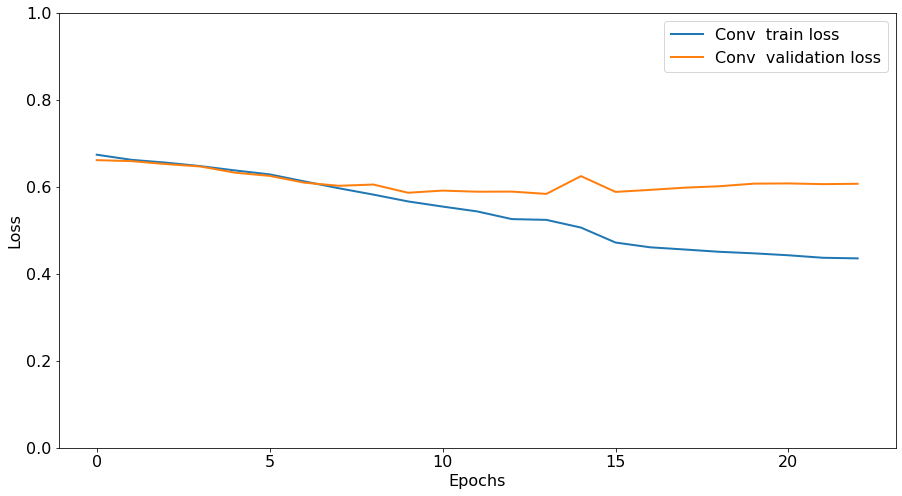

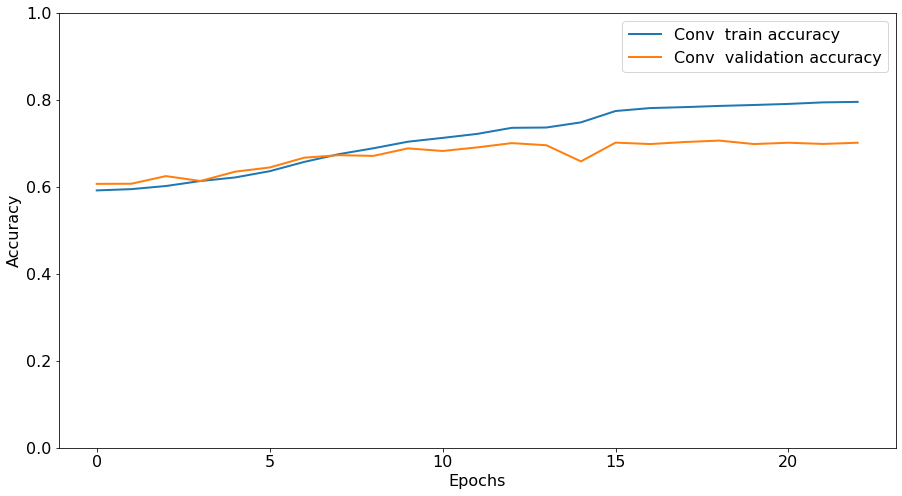

In [ ]:
plot_history(hs={'Conv ': history}, epochs=len(history.history['accuracy']), metric='loss')
plot_history(hs={'Conv ': history}, epochs=20, metric='accuracy')

Pre trained model


In [ ]:
def train_model(
        upper_layers_optimizer,
        full_network_optimizer,
        upper_layers_epochs=30,
        full_network_epochs=70,
        mlp_hidden_layers=[1024, 1024, 512],
        mlp_hidden_activation='relu',
        mlp_dropout=0.2,
        output_activation='softmax',
        callbacks=None,
        verbose=0):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_seed(1981) # Define the seed for Tensorflow to have reproducible experiments.

    base_model = InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape= (256, 256,3),
        pooling='max',
    )

    x = base_model.output
    # Define MLP layers.
    for i, units in enumerate(mlp_hidden_layers):
        x = Dense(
            units=units,
            kernel_initializer='glorot_uniform',
            activation=mlp_hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        if mlp_dropout > 0:
            x = Dropout(rate=mlp_dropout)(x)
   
    
    # Define the output layer.
    output = Dense(
        units=1,
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=base_model.input, outputs=output)

    # First train the upper layers for a few epochs
    for layer in base_model.layers:
        layer.trainable = False
    kappa = tfa.metrics.CohenKappa(num_classes=2,name='Kappa')
    model.compile(optimizer=upper_layers_optimizer, loss='binary_crossentropy', metrics=['accuracy',kappa])
    hs_upper_layers = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=upper_layers_epochs,
        verbose=verbose,
        callbacks=callbacks,
        )
    print('Finished training upper layers.')
    print('------------------')

    # Now train the whole network with a low learning rate
    for layer in base_model.layers:
        layer.trainable = True
    
    model.compile(optimizer=full_network_optimizer, loss='binary_crossentropy', metrics=['accuracy',kappa])

    hs_full_network = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=full_network_epochs,
        verbose=verbose,
        callbacks=callbacks,
       )
    print('Finished training full network.')
    print('------------------')

    model.summary() # Print a description of the model.
    return model, hs_upper_layers, hs_full_network

In [ ]:
train_generator = image_generator.flow_from_dataframe(train,x_col='path',y_col="label",class_mode="binary",batch_size=64,seed = 4)
val_generator = image_generator.flow_from_dataframe(val,x_col='path',y_col="label",class_mode="binary",batch_size=64,seed = 4)
test_generator = image_generator.flow_from_dataframe(test,x_col='path',y_col="label",class_mode="binary",batch_size=64,seed = 4)

# Using Adam
upper_layers_optimizer = Adam()
full_network_optimizer = Adam(1e-5)

early_stopping = ReturnBestEarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True,
            mode='max',
            verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.1,
                              cooldown=2,
                              mode='max',
                              patience=2)

vgg_model, vgg_hs, vgg_full_network_hs = train_model(
    upper_layers_optimizer=upper_layers_optimizer,
    full_network_optimizer=full_network_optimizer,
    upper_layers_epochs=30,
    full_network_epochs=70,
    mlp_hidden_layers=[512,512],
    mlp_hidden_activation='relu',
    mlp_dropout=0.2,
    output_activation='sigmoid',
    callbacks=[early_stopping,reduce_lr],
    verbose=1
)


Found 33170 validated image filenames belonging to 2 classes.
Found 3638 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.
219062272/219055592 [==============================] - 2s 0us/step
Epoch 1/30
519/519 [==============================] - 177s 342ms/step - loss: 0.6954 - accuracy: 0.6210 - Kappa: 0.1597 - val_loss: 0.6161 - val_accuracy: 0.6325 - val_Kappa: 0.0851 - lr: 0.0010
Epoch 2/30
519/519 [==============================] - 173s 334ms/step - loss: 0.6142 - accuracy: 0.6569 - Kappa: 0.2199 - val_loss: 0.5730 - val_accuracy: 0.7023 - val_Kappa: 0.3310 - lr: 0.0010
Epoch 3/30
519/519 [==============================] - 173s 334ms/step - loss: 0.5936 - accuracy: 0.6808 - Kappa: 0.2879 - val_loss: 0.5649 - val_accuracy: 0.7084 - val_Kappa: 0.3242 - lr: 0.0010
Epoch 4/30
519/519 [==============================] - 176s 339ms/step - loss: 0.5880 - accuracy: 0.6836 - Kappa: 0.2881 - val_loss: 0.5628 - val_accuracy: 0.7163 - 

In [ ]:
train_generator = image_generator.flow_from_dataframe(train,x_col='path',y_col="label",class_mode="binary",batch_size=256,seed = 4,shuffle=False)
val_generator = image_generator.flow_from_dataframe(val,x_col='path',y_col="label",class_mode="binary",batch_size=256,seed = 4,shuffle=False)
test_generator = image_generator.flow_from_dataframe(test,x_col='path',y_col="label",class_mode="binary",batch_size=256,seed = 4,shuffle=False)

pred_pretrained_train = vgg_model.predict(train_generator)
pred_pretrained_val = vgg_model.predict(val_generator)
pred_pretrained_test = vgg_model.predict(test_generator)

Found 33170 validated image filenames belonging to 2 classes.
Found 3638 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
predict(pred_pretrained_train,pred_pretrained_val)

Cohen Kappa 0.8579 for training data with t:0.421 
Accuracy score 0.9336 for training data  with t:0.421

Cohen Kappa 0.5929 for validation data  with t:0.421
Accuracy score 0.8120 for validation data  with t:0.421



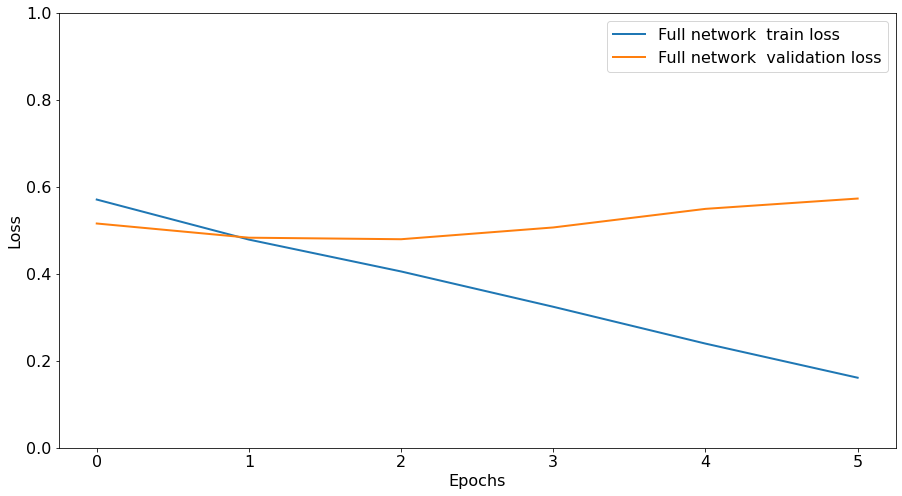

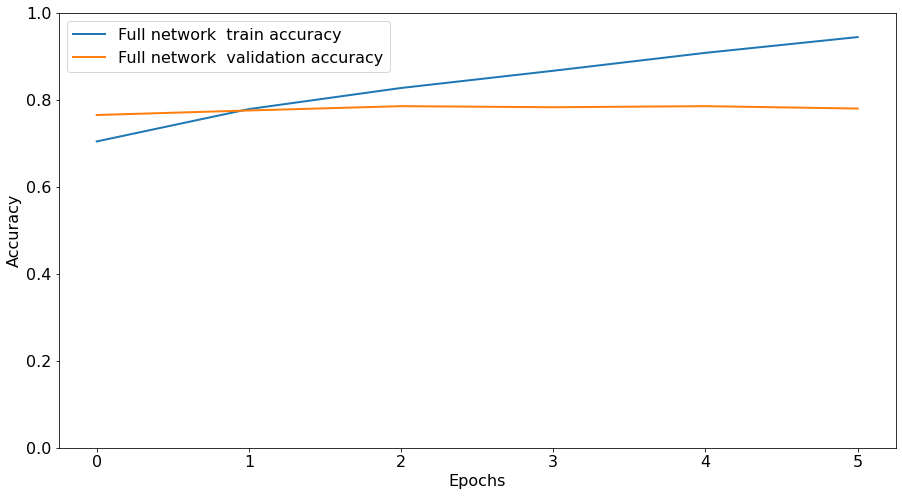

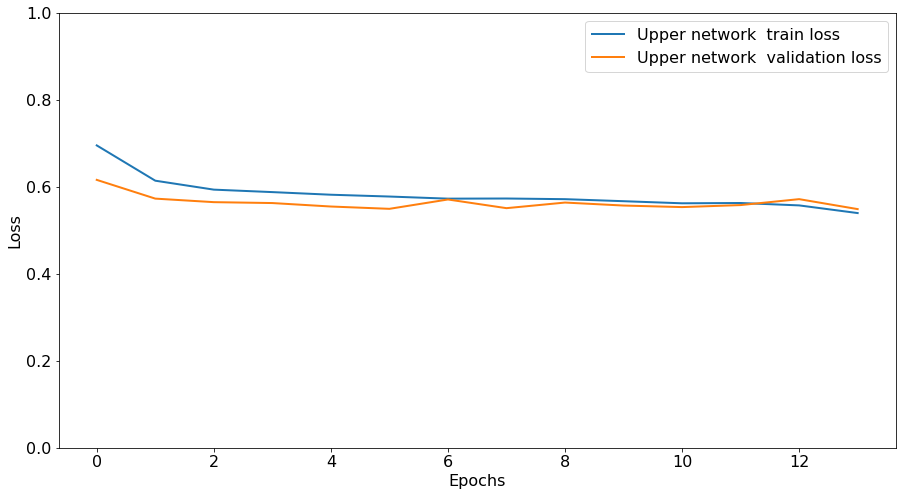

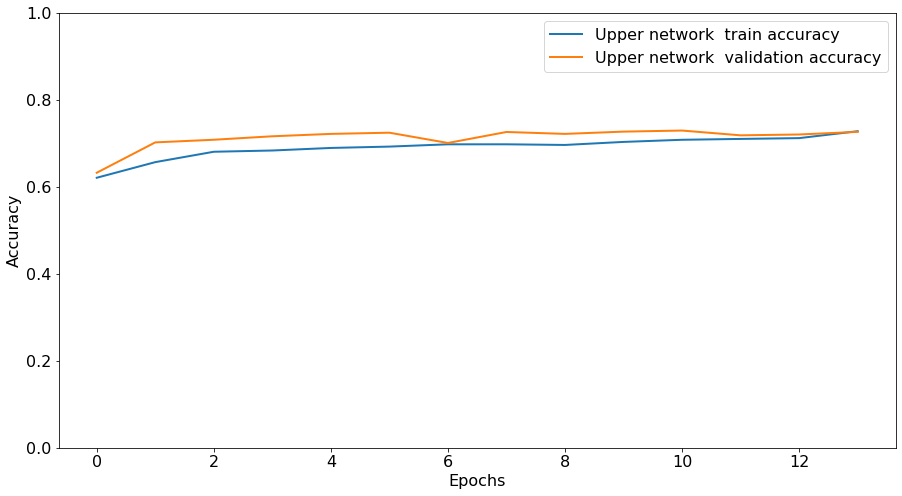

In [ ]:
plot_history(hs={'Full network ': vgg_full_network_hs}, epochs=len(vgg_full_network_hs.history['accuracy']), metric='loss')
plot_history(hs={'Full network ': vgg_full_network_hs}, epochs=20, metric='accuracy')

plot_history(hs={'Upper network ': vgg_hs}, epochs=len(vgg_hs.history['accuracy']), metric='loss')
plot_history(hs={'Upper network ': vgg_hs}, epochs=20, metric='accuracy')

In [ ]:
tf.keras.models.save_model(vgg_model, "/content/drive/My Drive/Colab Notebooks/inception_model.hp5", save_format="h5")
tf.keras.models.save_model(model, "/content/drive/My Drive/Colab Notebooks/custom_model.hp5", save_format="h5")

In [ ]:
from tensorflow import keras
kappa = tfa.metrics.CohenKappa(num_classes=2,name='Kappa')

vgg_model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/inception_model.hp5', custom_objects={'Kappa':kappa})
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/custom_model.hp5', custom_objects={'Kappa':kappa})

In [ ]:
train_generator = image_generator.flow_from_dataframe(train,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4,shuffle = False)
val_generator = image_generator.flow_from_dataframe(val,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4,shuffle = False)
test_generator = image_generator.flow_from_dataframe(test,x_col='path',y_col="label",class_mode="binary",batch_size=512,seed = 4,shuffle = False)

pred_train = model.predict(train_generator)
pred_val = model.predict(val_generator)
pred_test = model.predict(test_generator)

predict(pred_train,pred_val,pred_test)

Found 33170 validated image filenames belonging to 2 classes.
Found 3638 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.
Cohen Kappa 0.6549 for training data with t:0.474 
Accuracy score 0.8421 for training data  with t:0.474

Cohen Kappa 0.4386 for validation data  with t:0.474
Accuracy score 0.7422 for validation data  with t:0.474

Cohen Kappa 0.3854 for test data with t:0.474 
Accuracy score 0.7025 for test data  with t:0.474


In [ ]:
pred_pretrained_train = vgg_model.predict(train_generator)
pred_pretrained_val = vgg_model.predict(val_generator)
pred_pretrained_test = vgg_model.predict(test_generator)

predict(pred_pretrained_train,pred_pretrained_val,pred_pretrained_test)

Cohen Kappa 0.8579 for training data with t:0.421 
Accuracy score 0.9336 for training data  with t:0.421

Cohen Kappa 0.5929 for validation data  with t:0.421
Accuracy score 0.8120 for validation data  with t:0.421

Cohen Kappa 0.5752 for test data with t:0.421 
Accuracy score 0.7925 for test data  with t:0.421
